# **Extreme Gradient Boosting (XGBoost)**

## **Importing Libraries**

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

## **Loading Data**

In [2]:
df = pd.read_csv('datasets/combined_dataset.csv')

df.head(10)

,content,dataset,label
0,PrestaShop Recipes A Problem Solution Approach...,D3DreamMarket,NO
1,Nice post bond. Just remove typo - Or...,D4Garage4hackers,NO
2,Latest version of wifite (v2) has also inclu...,D4Garage4hackers,YES
3,"On Sunday, the 28th of November 2010 around ...",D4Garage4hackers,YES
4,I have to strongly disagree with the statement...,D2Twitter,NO
5,[RT] [USERNAME] Hack Remote Windows 10 Passwor...,D2Twitter,YES
6,how to crack realityking.com,D2CrackingFire,NO
7,THE BEST PRO WIFI HACKING TOOLS PACK 2017 Her...,D3DreamMarket,YES
8,[RT] [USERNAME] Analysing the NULL SecurityDes...,D2Twitter,YES
9,Quote: Originally Posted by ShockiNN Well the ...,D1CrackingArena,NO


## **Text Preprocessing**

In [3]:
df = df.drop(columns=['dataset'])

df.head(10)

,content,label
0,PrestaShop Recipes A Problem Solution Approach...,NO
1,Nice post bond. Just remove typo - Or...,NO
2,Latest version of wifite (v2) has also inclu...,YES
3,"On Sunday, the 28th of November 2010 around ...",YES
4,I have to strongly disagree with the statement...,NO
5,[RT] [USERNAME] Hack Remote Windows 10 Passwor...,YES
6,how to crack realityking.com,NO
7,THE BEST PRO WIFI HACKING TOOLS PACK 2017 Her...,YES
8,[RT] [USERNAME] Analysing the NULL SecurityDes...,YES
9,Quote: Originally Posted by ShockiNN Well the ...,NO


### **Step 1: Text Normalisation**

In [4]:
def normalisation(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)     # Remove links
    text = re.sub(r'[^a-zA-Z\s]', '', text)                 # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()                # Remove extra spaces
    return text.lower()                                     # Convert to lowercase

df['content'] = df['content'].apply(normalisation)
df.head(10)

,content,label
0,prestashop recipes a problem solution approach...,NO
1,nice post bond just remove typo originally pos...,NO
2,latest version of wifite v has also included t...,YES
3,on sunday the th of november around utc the ma...,YES
4,i have to strongly disagree with the statement...,NO
5,rt username hack remote windows password in pl...,YES
6,how to crack realitykingcom,NO
7,the best pro wifi hacking tools pack here we f...,YES
8,rt username analysing the null securitydescrip...,YES
9,quote originally posted by shockinn well the s...,NO


### **Step 2: Stopwords Removal**

In [5]:
stop_words = set(stopwords.words('english'))

df['content'] = df['content'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

### **Step 3: Tokenisation and Lemmatization**

In [6]:
lemmatizer = WordNetLemmatizer()

df['content'] = df['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

df.head(10)

,content,label
0,prestashop recipe problem solution approach cu...,NO
1,nice post bond remove typo originally posted b...,NO
2,latest version wifite v also included attack v...,YES
3,sunday th november around utc main brdistribut...,YES
4,strongly disagree statement story phone hacked...,NO
5,rt username hack remote window password plain ...,YES
6,crack realitykingcom,NO
7,best pro wifi hacking tool pack figured three ...,YES
8,rt username analysing null securitydescriptor ...,YES
9,quote originally posted shockinn well site gav...,NO


## **Model Training**

In [7]:
vectorizer = CountVectorizer(max_features=1000)

X = vectorizer.fit_transform(df['content']).toarray()
y = df['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 1692
Testing set size: 424


In [8]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

## **Model Evaluation**

In [9]:
def calculate_metrics(y_true, y_pred, conf_matrix):
    tn, fp, _, _ = conf_matrix.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1-score": f1
    }

    return metrics

def display_metrics(metrics):
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.ljust(12)}: {metric_value * 100:.2f}%")

In [10]:
print("XGBoost Performance:")
print(classification_report(y_test, xgb_pred))
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       217
           1       0.89      0.93      0.91       207

    accuracy                           0.91       424
   macro avg       0.91      0.91      0.91       424
weighted avg       0.91      0.91      0.91       424

Accuracy: 0.9080


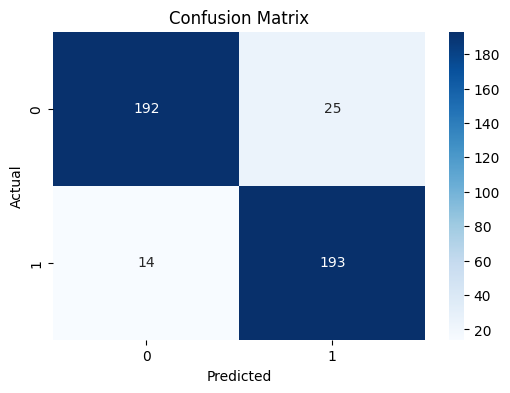

Accuracy    : 90.80%
Precision   : 88.53%
Recall      : 93.24%
Specificity : 88.48%
F1-score    : 90.82%


In [11]:
conf_matrix_test = confusion_matrix(y_test, xgb_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=xgb.classes_, yticklabels=xgb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

metrics_test = calculate_metrics(y_test, xgb_pred, conf_matrix_test)
display_metrics(metrics_test)

## **Hyperparameter Tuning**

In [12]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 1.0]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
tuned_xgb = xgb_grid_search.best_estimator_

tuned_xgb_pred = tuned_xgb.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


## **Final Evaluation**

In [13]:
print("XGBoost Performance after Hyperparameter Tuning:")
print(classification_report(y_test, tuned_xgb_pred))
print(f"Accuracy: {accuracy_score(y_test, tuned_xgb_pred):.4f}")

XGBoost Performance after Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       217
           1       0.89      0.94      0.91       207

    accuracy                           0.91       424
   macro avg       0.91      0.91      0.91       424
weighted avg       0.91      0.91      0.91       424

Accuracy: 0.9127


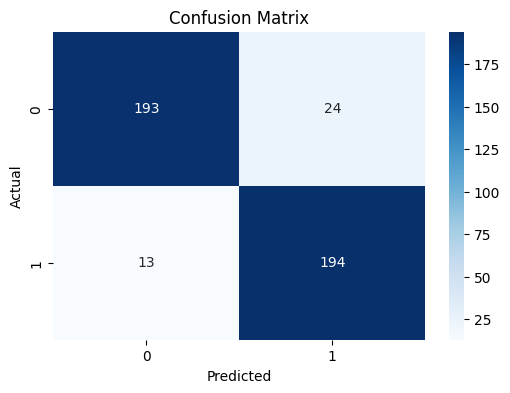

Accuracy    : 91.27%
Precision   : 88.99%
Recall      : 93.72%
Specificity : 88.94%
F1-score    : 91.29%


In [14]:
conf_matrix_test = confusion_matrix(y_test, tuned_xgb_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=tuned_xgb.classes_, yticklabels=tuned_xgb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

metrics_test = calculate_metrics(y_test, tuned_xgb_pred, conf_matrix_test)
display_metrics(metrics_test)